# Model Iteration 1
### SF-Crime Kaggle Challenge      2.23.16
##### Data Science 2016 - CYOA Project.
_______________________________________________________

##### Olin College
##### David Abrahams & Brenna Manning


#### Imports

In [30]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy.stats as st
import random
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrix, dmatrices
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

#### Load Data

In [31]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))
mapdata = np.loadtxt(os.path.join(cur_dir, "data", "sf_map.txt"))

#### Functions to be used later

In [32]:
def get_random_subset(df, n=5000):
    sub = random.sample(xrange(len(df)), min(n, len(df)))
    return df.iloc[sub]

def preprocess(df):
    res = df.copy()
    res = res[res.X != res.X.max()]
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    res['DOW'] = train.DayOfWeek.apply(lambda x: dow.index(x))
    res['Street_Corner'] = res['Address'].apply(lambda x: 1 if '/' in x else 0)
    return res

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def isNight(hour):
    if hour in [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]:
        return "Night"
    else:
        return "Day"

#### Preprocess the full dataset

In [33]:
train_df = preprocess(get_random_subset(train, len(train)))

#### View the data

In [34]:
print train_df.describe()

                   X              Y           Hour          Month  \
count  877982.000000  877982.000000  877982.000000  877982.000000   
mean     -122.422763      37.767035      13.412737       6.436416   
std         0.025285       0.024165       6.549521       3.428998   
min      -122.513642      37.707879       0.000000       1.000000   
25%      -122.432952      37.752427       9.000000       3.000000   
50%      -122.416420      37.775421      14.000000       6.000000   
75%      -122.406959      37.784368      19.000000       9.000000   
max      -122.364937      37.819975      23.000000      12.000000   

        Hour_Minutes  Minutes_Since_03  Minutes_Since_New_Year            DOW  \
count  877982.000000     877982.000000           877982.000000  877982.000000   
mean       13.748657    3263716.192895           259058.977781       2.992719   
std         6.560013    1908460.344165           151054.164970       1.972028   
min         0.016667       7201.000000                

#### Tuning Parameters of Random Forest
We separately found that min_samples_leaf was the only parameter that appeared to have significant impact on the Random Forest's performance for this dataset.

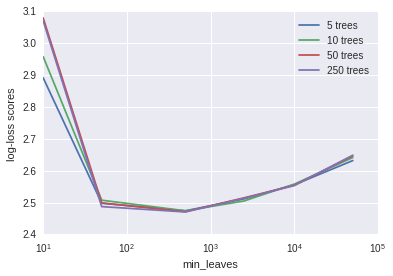

In [35]:
training, validation = train_test_split(train_df, train_size=.60)

formula_ml = 'X+Y+Hour'
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + Street_Corner + X+Y+Hour+Month'
x_train = dmatrix(formula_ml, data=training, return_type='dataframe')
# print x_train
y_train = training.Category

x_validation = dmatrix(formula_ml, data=validation, return_type='dataframe')
y_validation = validation.Category

x_validation = x_validation[y_validation.isin(y_train.values)]
# y_validation = y_validation[y_validation.isin(y_train.values)]
# mlb = MultiLabelBinarizer(classes=alg.classes_)
# print y_validation
# y_validation = mlb.fit_transform(np.array([y_validation]).T)

num_trees = [5, 10, 50, 250]
min_leaves = [10, 50, 500, 2500, 10000, 50000]

for trees in num_trees:
    scores = []
    for l in min_leaves:
        alg = RandomForestClassifier(min_samples_leaf=l)
        alg.fit(x_train, y_train)
        # alg = BernoulliNB()
        y_validation = validation.Category
        y_validation = y_validation[y_validation.isin(y_train.values)]
        mlb = MultiLabelBinarizer(classes=alg.classes_)
        y_validation = mlb.fit_transform(np.array([y_validation]).T)

        predictions = np.array(alg.predict_proba(x_validation))
        scores.append(log_loss(y_validation, predictions))
    #     print "Min leaf " + str(l) + ": " + str(log_loss(y_validation, predictions))
    plt.plot(min_leaves, scores, label=(str(trees) + " trees"))
plt.legend()
plt.xlabel('min_leaves')
plt.ylabel('log-loss scores')
plt.gca().set_xscale('log')

#### Comparing Random Forest and Bernoulli

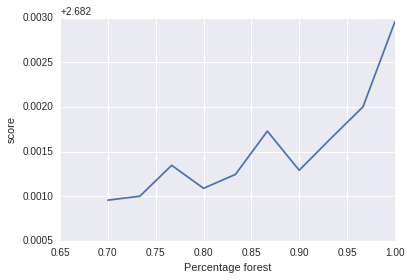

In [36]:
training, validation = train_test_split(train_df, train_size=.60)

formula_ml = 'C(DayOfWeek) + C(PdDistrict) + Street_Corner + X+Y+Hour+Month'
x_train = dmatrix(formula_ml, data=training, return_type='dataframe')
# print x_train
# y_train = training.Category

x_validation = dmatrix(formula_ml, data=validation, return_type='dataframe')
y_validation = validation.Category

x_validation = x_validation[y_validation.isin(y_train.values)]
# y_validation = y_validation[y_validation.isin(y_train.values)]
# mlb = MultiLabelBinarizer(classes=alg.classes_)
# print y_validation
# y_validation = mlb.fit_transform(np.array([y_validation]).T)

weights = np.linspace(0.7, 1, 10)
scores = []

for w in weights:
    alg1 = RandomForestClassifier(min_samples_leaf=1000)
    alg2 = BernoulliNB()
    alg1.fit(x_train, y_train)
    alg2.fit(x_train, y_train)
    # alg = BernoulliNB()
    y_validation = validation.Category
    y_validation = y_validation[y_validation.isin(y_train.values)]
    mlb = MultiLabelBinarizer(classes=alg1.classes_)
    y_validation = mlb.fit_transform(np.array([y_validation]).T)

    predictions1 = np.array(alg1.predict_proba(x_validation))
    predictions2 = np.array(alg2.predict_proba(x_validation))
    predictions = (w * predictions1 + (1-w) * predictions2)
    score = log_loss(y_validation, predictions)
    scores.append(score)
    #     print "Min leaf " + str(l) + ": " + str(log_loss(y_validation, predictions))
plt.plot(weights, scores)
plt.xlabel("Percentage forest")
plt.ylabel("score")
# plt.gca().set_xscale('log')

#### Log Loss Scores for each value of the min_samples_leaf parameter

In [37]:
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + Street_Corner + X+Y+Hour+Month'

x_vals = dmatrix(formula_ml, data=train_df, return_type='dataframe')
y_vals = train_df.Category

min_leaves = [10, 50, 500, 2500, 10000, 50000]

parameters = {'min_samples_leaf':min_leaves}

clf = GridSearchCV(RandomForestClassifier(), parameters, scoring='log_loss')

clf.fit(x_vals, y_vals)

print clf.grid_scores_

[mean: -3.03685, std: 0.04824, params: {'min_samples_leaf': 10}, mean: -2.49850, std: 0.00625, params: {'min_samples_leaf': 50}, mean: -2.46725, std: 0.00078, params: {'min_samples_leaf': 500}, mean: -2.51232, std: 0.00186, params: {'min_samples_leaf': 2500}, mean: -2.55342, std: 0.00305, params: {'min_samples_leaf': 10000}, mean: -2.62584, std: 0.00394, params: {'min_samples_leaf': 50000}]


#### These results were not officially submitted to Kaggle, but were used to develop later models.